# GLMの応用範囲をひろげる-ロジスティック回帰など-

## 上限のあるカウントデータ
- 上限のあるカウントデータは二項分布で表現できる
- 例えば、N個体の実験対象に同じ処理をしたら、y個体で反応が陽性、N-y個体で陰性であったといった場合。この時はyがNという上限を持つ

## 例題データの説明
植物の種子数を観察し、生存している種子数を$y_i$,生存していない種子数を$N_i-y_i$とする。主なデータは以下
- 観察種子数$N_i$はどの個体でも8個とする.（上限は8）
- 個体iの種子の生存確率を$q_i$とする
- 個体の大きさを示す体サイズを$x_i$とする
- 全個体100個体のうち、50個は肥料を与えず($f_i=C$)、50個は肥料を与えた($f_i=T$)
- 今回調べることは、生存確率$q_i$が$x_i,f_i$によってどのように変化するか

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [23]:
data = pd.read_csv('data4a.csv',dtype={'y':int,'x':float,'f':'category'})
data.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [24]:
data.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


In [25]:
data.f.describe()

count     100
unique      2
top         T
freq       50
Name: f, dtype: object

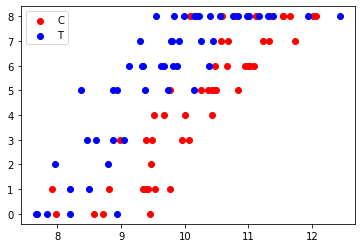

In [26]:
# データをプロットして確認
x_c = data.x[data.f=='C']
y_c = data.y[data.f=='C']

x_t = data.x[data.f=='T']
y_t = data.y[data.f=='T']

plt.scatter(x_c,y_c,c='red',label='C')
plt.scatter(x_t,y_t,c='blue',label='T')
plt.legend()
plt.show()

- プロットより、$x_i$が大きいほど生存種子数は多そう
- 肥料をやる($f_i=T$)と、生存種子数は増えそう

## なぜ「N個のうちy個生存していた」のような上限ありカウントデータを二項分布で表現するか

- 二項分布の確率分布は下記で示され、0以上で上限が設定されたものになるから
$$
p(y|N,q) = \dbinom{N}{y}q^{y}(1-q)^{N-y}
$$
- ポアソン分布の場合、平均はあるが、上限はない

下記に二項分布の確率分布を示す

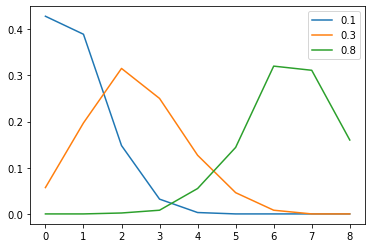

In [27]:
# 確率qのリスト
q_list = [0.1,0.3,0.8]
# 確率分布を入れるp_dictsを作っておく
p_dicts = dict()
# qに確率を順番に適用
for q in q_list:
  # 空のdict型を生成
  p_dict = dict()
  # 0～8まで、0:0,1:0…8:0という形でdict型に格納
  for i in range(0,9):
    p_dict.update({i:0})
  # np.random.binomial(n, p=q)で、上限n個、確率qの二項分布に従う乱数を作成
  # 作成した乱数に対応するp_dictの値を1追加,1000回繰り返す
  for _ in range(1000):
    rnd = np.random.binomial(8,p=q)
    p_dict[rnd] += 1
  # p_dictの中身をそれぞれ回数1000回で割り、確率分布に変更
  for i in range(0,9):
    p_dict[i] /= 1000
  p_dicts.update({q: p_dict})

for param,dictionary in p_dicts.items():
  plt.plot(list(dictionary.keys()),list(dictionary.values()),label=str(param))
  plt.legend()

## ロジスティック回帰とロジットリンク関数
ロジスティック回帰 : 二項分布を使ったGLMのひとつ

### ロジットリンク関数
GLM → 確率分布・リンク関数・線形予測子を指定する統計モデル
GLMのひとつであるロジスティック回帰は
ロジスティック回帰 → 確率分布：二項分布・リンク関数：ロジットリンク関数を指定  
種子のデータにおける例  
種子の生存・非生存を表現する分布として二項分布を指定した
$$
二項分布：p(y|N,q) = \dbinom{N}{y}q^{y}(1-q)^{N-y}
$$
二項分布はパラメータとして生存確率$q_i$を指定する必要がある。$q_i$は確率なので$0 \leqq q_i\leqq 1$である。  
**これを表現する必要あり！！**  
まず、ロジスティック関数について説明  
$$
ロジスティック関数 ： q_i = logistic(z_i) = \frac{1}{1+e^{-z_i}}\\
ただし、z_iは線形予測子 z_i = β_1 + β_2x_i + … 
$$
以下、ロジスティック関数を作図して概要を把握

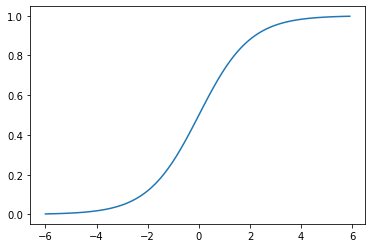

In [28]:
# ロジスティック関数におけるq_iを返す関数を定義
def sigmoid(x):
  # ここで線形予測子としての式を定義。今回は単純にz = x
  z = x
  return 1/(1+np.exp(-z))

x = np.arange(-6,6,0.1)
y = sigmoid(x)

plt.plot(x,y)

上記より、$0 \leqq q_i \leqq 1$が表現されている.  

### ロジット関数
ロジスティック関数を式変形
$$
log\frac{q_i}{1-q_i} = z_i\\
ここで、(左辺) = logit(q_i) = log\frac{q_i}{1-q_i}
$$
つまり、ロジット関数とロジスティック関数は互いに逆関数である。

## パラメータ推定
- 統計モデルにデータを当てはめ、パラメータを最尤推定する
- 二項分布の尤度関数
$$
L({β_j}) = \prod_{i}\dbinom{N_i}{y_i}(q_i)^{y_i}(1 - q_i)^{N_i - y_i}\\
logL({β_j}) = \sum_{i}\{log\dbinom{N_i}{y_i} + y_ilog(q_i) + (N_i - y_i)log(1 - q_i)\}\\
ただし、q_iはβの関数
$$
今回の例では、対サイズ$x_i$と施肥処理の有無$f_i$を使うため、$z_i=β_1+β_2x_i+β_3f_i$として、$q_i=\frac{1}{1+e^{-z_i}}$とする。

In [29]:
data.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [30]:
data.shape

(100, 4)

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# y+I(N-y)は、生存種子y,非生存種子数N-yの二項分布であることを指定してる
model = smf.glm('y+I(N-y)~x+f',data=data,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sun, 08 Aug 2021   Deviance:                       123.03
Time:                        11:53:18   Pearson chi2:                     109.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

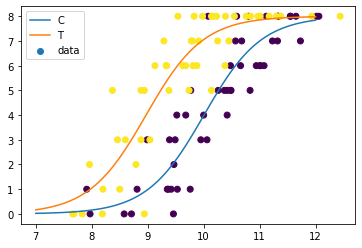

In [32]:
df_test_c = pd.DataFrame()
df_test_c["x"] = np.linspace(7,12,100)
df_test_c["f"] = "C"
predict_c = result.predict(df_test_c)*8

df_test_t = pd.DataFrame()
df_test_t["x"] = np.linspace(7,12,100)
df_test_t["f"] = "T"
predict_t = result.predict(df_test_t)*8

plt.plot(df_test_c.x,predict_c,label="C")
plt.plot(df_test_t.x,predict_t,label="T")
plt.scatter(data.x,data.y,c=data.f.cat.codes,label="data")
plt.legend()

Text(0.5, 1.0, 'T')

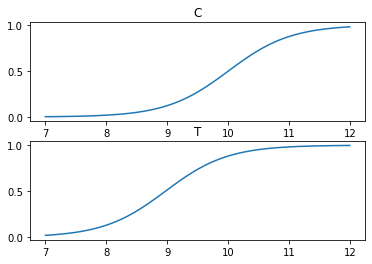

In [33]:
# predictを用いずに
b1 = result.params[0]
b2 = result.params[2]
b3 = result.params[1]

x = np.linspace(7,12,100)
z_c = x*b2 + b1
z_t = x*b2 + b1 + b3
y_c = sigmoid(z_c)
y_t = sigmoid(z_t)

plt.subplot(2,1,1)
plt.plot(x,y_c)
plt.title('C')

plt.subplot(2,1,2)
plt.plot(x,y_t)
plt.title('T')

## ロジットリンク関数の意味・解釈

ロジット関数は以下の様に式変形される
$$
\begin{align}
logit(q_i) = z_i &= log\frac{q_i}{1-q_i}\\
\frac{q_i}{1-q_i} = e^{線形予測子} &= e^{z_i}\\
&=e^{β_1+β_2x_i+β_3f_i}
&=e^{β_1}e^{β_2x_i}e^{β_3f_i}
\end{align}
$$
ここで、$\frac{q_i}{1-q_i}$をオッズという。  
つまり、オッズは定数項を無視すると、以下の比例関係が成立する
$$
\frac{q_i}{1-q_i} \propto e^{β_2x_i}e^{β_3f_i}
$$
つまり、オッズは$x_i$の値が1単位増加すると、$e^{β_2}$倍大きくなる。  
また、オッズの対数をとったものが、
$$
log\frac{q_i}{1-q_i} = β_1+β_2x_i+β_3f_i = 線形予測子z_i
$$
オッズ比は近似的にリスクと同値になる。

## ロジスティック回帰のモデル選択

- 生存種子数を最もよく予測する統計モデル化を知りたい
- AICによるモデル選択 → 最もよく予測できるモデルを選択する。
- $AIC = -2(logL^{*} - k)$ → $logL^{*}は最大対数尤度であり、kはパラメータ数
- kはパラメータによる最大対数尤度の改善に近似できるため、AICはパラメータ数の影響を除いた最大対数尤度といえる。

In [38]:
# 定数項のみ、fのみ、xのみ、xとfのすべての場合の統計モデルについて、
# GLMによる二項分布でのモデル構築、結果を格納
results = []
AIC_results = []
formula_list = ['y+I(N-y)~1','y+I(N-y)~f','y+I(N-y)~x','y+I(N-y)~x+f']
for formula in formula_list:
  model = smf.glm(formula,data=data,family=sm.families.Binomial())
  result = model.fit()
  results.append(result)
  AIC_results.append(-2*(result.llf - (result.df_model+1)))

In [45]:
# AICの結果を表示
for i in range(len(formula_list)):
  print(formula_list[i],AIC_results[i])

y+I(N-y)~1 644.4093416623778
y+I(N-y)~f 637.7597534566678
y+I(N-y)~x 364.34544328371584
y+I(N-y)~x+f 272.2111292852234


- AICの観点ではxとfのモデルが一番よさそう

## 交互作用項の入った線形予測子

例えば、対サイズ$x_i$と施肥処理の有無$f_i$の交互作用を入れ込んだモデルは以下
$$
logit(q_i) = z_i = β_1+β_2x_i+β_3f_i+β_4x_if_i
$$
- 以下で推定してみる

In [47]:
model = smf.glm('y+I(N-y)~x*f',data=data,family=sm.families.Binomial())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       96
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -132.81
Date:                Sun, 08 Aug 2021   Deviance:                       122.43
Time:                        12:24:08   Pearson chi2:                     109.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.5233      1.886     -9.821      0.000     -22.220     -14.827
f[T.T]        -0.0638      2.704     -0.024      0.981      -5.363       5.235
x              1.8525      0.186      9.983      0.000       1.489       2.216
x:f[T.T]       0.2163      0.280      0.772      0.440      -0.333       0.765
==============================================================================
"""

- ここでx*fの係数はx:f[T.T]で示されている

In [49]:
aic = -2*(result.llf - (result.df_model + 1))
aic

273.61059672597395

- 今回の場合、交互作用を追加してもAICは改善しなかった。
- 交互作用を入れるとサマリーで見ても判断しにくいから、グラフを書いて比較するとよい
- 交互作用をむやみに入れると解釈が難しくなるからむやみやたらに入れない
- むやみに入れると変数の増加とともに組み合わせ論爆発的に増える。
- 現実データで、説明変数で説明できない「個体差」「場所差」によるばらつきを考慮していないGLMに当てはめたとき、交互作用を含んだ過度に複雑なモデルが選択される傾向がある。